In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

def load_and_preprocess_adult_data(data_url):
    """
    Download and preprocess the UCI Adult dataset.

    Features (X): use only:
       'age', 'education-num', 'marital-status', 'occupation', 'hours-per-week'
    Observed Label (Y): derived from 'income' (binary: 1 if '>50K', 0 otherwise)
    Sensitive attribute (S): derived from 'sex' (binary: 1 if 'Male', 0 if 'Female')

    Returns:
      X: numpy array of shape (n_samples, 5)
      Y: 1-D numpy array of observed labels.
      S: 1-D numpy array of sensitive attribute.
    """
    col_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                 "marital-status", "occupation", "relationship", "race", "sex",
                 "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
    data = pd.read_csv(data_url, header=None, names=col_names, na_values=" ?", skipinitialspace=True)
    data.dropna(inplace=True)

    # Features
    feature_cols = ["age", "education-num", "marital-status", "occupation", "hours-per-week"]
    X = data[feature_cols].copy()
    for col in X.columns:
        if X[col].dtype == object:
            X[col] = pd.Categorical(X[col]).codes
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values.astype(np.float32))

    # Observed label
    data['income'] = data['income'].apply(lambda s: s.replace('.', '').strip())
    y_binary = (data['income'] == '>50K').astype(np.int32)
    Y = y_binary.values  # 1-D array

    # Sensitive attribute
    S = (data['sex'].str.strip() == 'Male').astype(np.int32).values  # 1-D array

    return X, Y, S

# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Main branch (encoder): from X, several dense layers produce a latent pseudo‑label pseudo_Y (via sigmoid).
      - Adversary branch: pseudo_Y is passed through a Gradient Reversal Layer and then dense layers predict S.
      - Decoder branch: concatenates pseudo_Y and the one-hot sensitive attribute S to predict the observed label Y.

    Losses:
      - For the main branch, binary crossentropy between observed Y and pseudo_Y (and Y_pred).
      - For the adversary branch, categorical crossentropy to predict S.

    Returns a compiled Keras model that takes inputs X and S (one-hot encoded) and outputs:
      [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # one-hot encoded S

    # Main branch: Encoder for pseudo-label.
    h = Dense(64, activation='relu')(X_input)
    h = BatchNormalization()(h)
    h = Dense(32, activation='relu')(h)
    h = BatchNormalization()(h)
    pseudo_Y = Dense(1, activation='sigmoid', name="pseudo_Y")(h)

    # Adversary branch: from pseudo_Y, with GRL.
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = Dense(32, activation='relu')(grl)
    a = BatchNormalization()(a)
    S_pred = Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch: combine pseudo_Y and S to predict observed Y.
    concat = Concatenate()([pseudo_Y, S_input])
    d = Dense(16, activation='relu')(concat)
    d = BatchNormalization()(d)
    Y_pred = Dense(1, activation='sigmoid', name="Y_pred")(d)

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "binary_crossentropy",
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "binary_crossentropy"},
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"})
    return model

# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually.
    y_true: binary ground-truth labels (1-D numpy array).
    y_pred: continuous scores (will be thresholded at 0.5).
    sensitive_features: 1-D numpy array (0 or 1).

    Returns a dictionary with:
      - Demographic parity difference (absolute difference in positive rates).
      - Equalized odds difference (average difference in TPR and FPR).
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_bin = (y_pred > 0.5).astype(int)
    groups = np.unique(sensitive_features)

    # Demographic parity
    pos_rates = {}
    for g in groups:
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1])

    # Equalized odds
    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8)
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8)
        metrics[g] = (tpr, fpr)
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) / 2

    # Selection rate per group.
    sel_rate = {}
    for g in groups:
        sel_rate[g] = pos_rates[g]

    # Group-wise accuracy.
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }

# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -------------------------------
# Main Function: Comparison and Visualization
# -------------------------------
def main(data_url, lambda_adv=1.0):
    set_seed(42)

    print("Loading and preprocessing Adult data...")
    X, Y_obs, S = load_and_preprocess_adult_data(data_url)
    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )

    print(f"Features shape: {X.shape}")
    print(f"Observed Label Y shape: {Y_obs.shape}   (Label from 'income')")
    print(f"Sensitive Attribute (Sex) shape: {S.shape}")

    input_dim = X_train.shape[1]

    # One-hot encode S for adversarial model training.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model (X → Y' with adversary)
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)
    # For training, we use the observed Y as target for both pseudo_Y and Y_pred.
    # Reshape Y_obs to (-1,1) since our outputs are scalars.
    Y_train_obs_exp = Y_train_obs.reshape(-1, 1)
    Y_test_obs_exp  = Y_test_obs.reshape(-1, 1)
    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_obs_exp, "S_pred": S_train_oh, "Y_pred": Y_train_obs_exp},
                  epochs=30, batch_size=128, verbose=1)

    # Get pseudo-label predictions.
    pseudo_Y_train, _, _ = adv_model.predict([X_train, S_train_oh])
    pseudo_Y_test,  _, _ = adv_model.predict([X_test, S_test_oh])

    # Threshold pseudo-labels to get binary labels.
    pseudo_Y_train_bin = (pseudo_Y_train > 0.5).astype(np.float32)
    pseudo_Y_test_bin  = (pseudo_Y_test > 0.5).astype(np.float32)

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-positive rate: {np.mean(pseudo_Y_train_bin[mask]):.4f}")

    ### 2. Train baseline logistic regression model on observed Y (X → Y)
    print("\nTraining baseline logistic regression classifier (X → Y)...")
    baseline_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    baseline_clf.fit(X_train, Y_train_obs)
    baseline_preds = baseline_clf.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(Y_test_obs, baseline_preds)
    baseline_acc = accuracy_score(Y_test_obs, (baseline_preds > 0.5).astype(int))
    baseline_fairness = compute_fairness_metrics_manual(Y_test_obs, baseline_preds, sensitive_features=S_test)

    ### 3. Train fair logistic regression model on pseudo-labels (X → Y')
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo-labels...")
    fair_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    fair_clf.fit(X_train, pseudo_Y_train_bin.ravel())
    fair_preds = fair_clf.predict_proba(X_test)[:, 1]
    fair_auc = roc_auc_score(Y_test_obs, fair_preds)
    fair_acc = accuracy_score(Y_test_obs, (fair_preds > 0.5).astype(int))
    fair_fairness = compute_fairness_metrics_manual(Y_test_obs, fair_preds, sensitive_features=S_test)

    # Aggregate metrics for plotting.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparison.
    plot_comparison(metrics_baseline, metrics_fair)

if __name__ == '__main__':
    adult_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    main(adult_data_url, lambda_adv=5.0)


Loading and preprocessing Adult data...
Features shape: (32561, 5)
Observed Label Y shape: (32561,)   (Label from 'income')
Sensitive Attribute (Sex) shape: (32561,)

Training adversarial model (X → Y' with adversary) ...


NameError: name 'Dense' is not defined

Loading and preprocessing German Credit data...
Features shape: (1000, 3)
Observed Label Y shape: (1000,)   (Credit risk: 1=good, 0=bad)
Sensitive Attribute (Age, binarized) shape: (1000,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - S_pred_accuracy: 0.4813 - S_pred_loss: 0.7957 - Y_pred_accuracy: 0.5168 - Y_pred_loss: 1.0087 - loss: 14.2400 - pseudo_Y_accuracy: 0.5160 - pseudo_Y_loss: 0.8470
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - S_pred_accuracy: 0.4830 - S_pred_loss: 0.7956 - Y_pred_accuracy: 0.5186 - Y_pred_loss: 0.9970 - loss: 14.2264 - pseudo_Y_accuracy: 0.5139 - pseudo_Y_loss: 0.8494  
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - S_pred_accuracy: 0.4771 - S_pred_loss: 0.7941 - Y_pred_accuracy: 0.5208 - Y_pred_loss: 0.9859 - loss: 14.1885 - pseudo_Y_accuracy: 0.5216 - pseudo_Y_loss: 0.8491
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - S_pred_accuracy: 0.4740 - S_pred_loss: 0.7925 - Y_pred_accuracy:

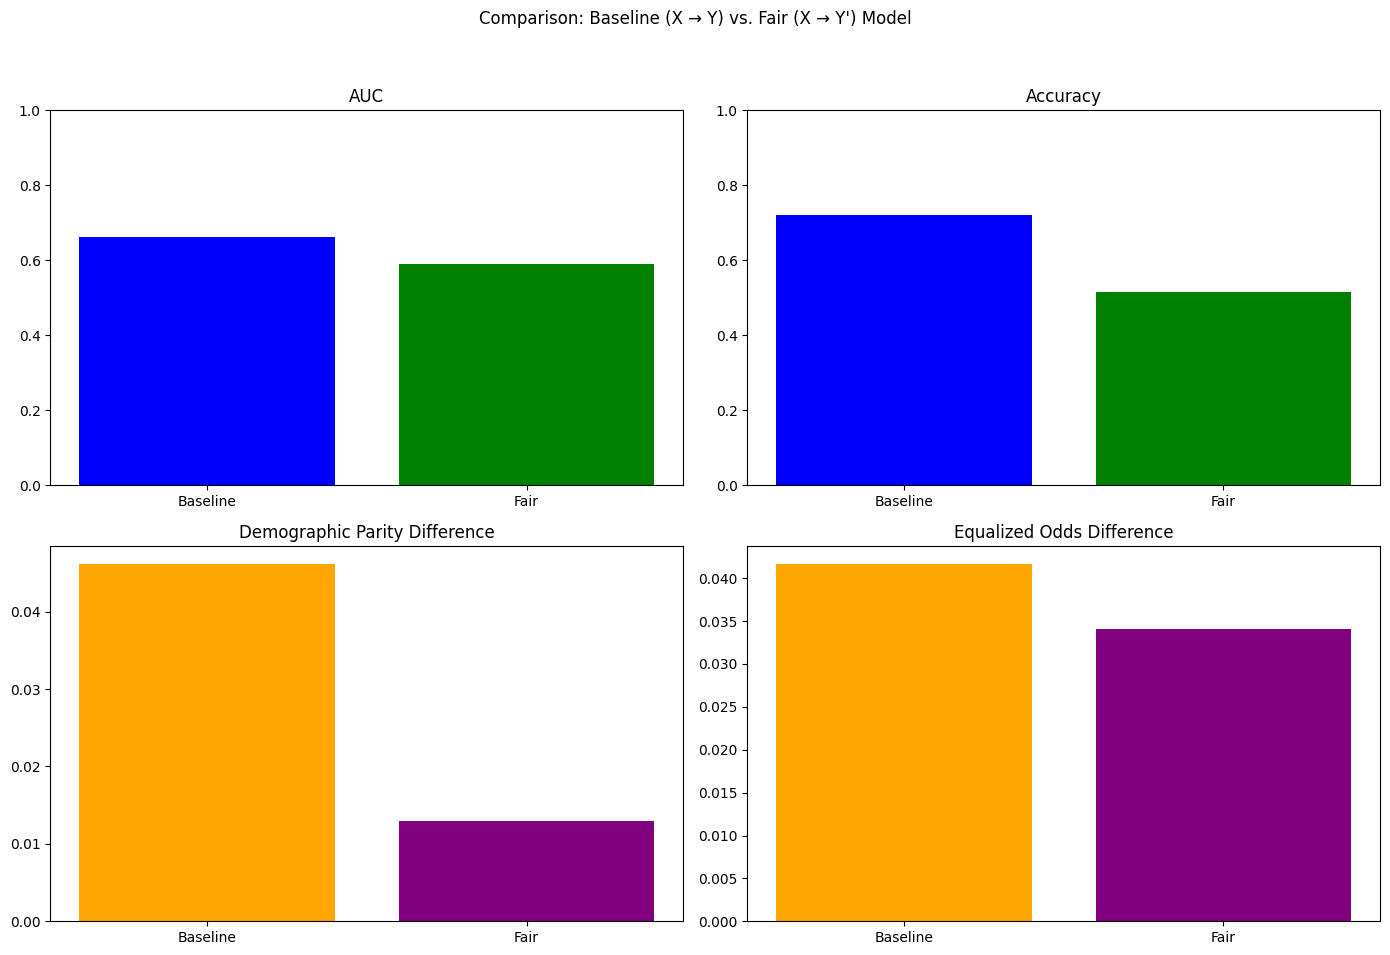

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing for German Credit Data
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

def load_and_preprocess_german_data(data_url):
    """
    Download and preprocess the German Credit dataset.

    We assume the dataset has 21 columns.

    Features (X): Use only:
        "duration", "credit_amount", "inst_rate"
    Observed Label (Y): from "target". In many versions, target is coded as 1 for good and 2 for bad.
        We recode: good (1) -> 1, bad (2) -> 0.
    Protected Attribute (S): Use the "age" column.
        We binarize age by computing the median and setting S = 1 if age >= median (older), else 0.
    """
    col_names = ["chk_status", "duration", "credit_history", "purpose", "credit_amount",
                 "savings", "employment", "inst_rate", "personal_status_sex", "other_debtors",
                 "residence_since", "property", "age", "other_installment_plans", "housing",
                 "num_credits", "job", "num_dependents", "telephone", "foreign_worker", "target"]
    data = pd.read_csv(data_url, header=None, names=col_names, sep=' ', engine='python')

    # Features: use only duration, credit_amount, and inst_rate.
    feature_cols = ["duration", "credit_amount", "inst_rate"]
    X = data[feature_cols].copy().astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values)

    # Observed label: target. Recode so that 1 -> 1 (good) and 2 -> 0 (bad)
    Y = data["target"].values
    Y = np.where(Y == 1, 1, 0)

    # Protected attribute: use age.
    # Convert age to float and then binarize by the median.
    age_vals = data["age"].astype(np.float32).values
    median_age = np.median(age_vals)
    S = (age_vals >= median_age).astype(np.int32)

    return X, Y, S

# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Encoder branch: from X, dense layers produce pseudo_Y (scalar via sigmoid).
      - Adversary branch: applies a Gradient Reversal Layer on pseudo_Y and predicts S (2-class softmax).
      - Decoder branch: concatenates pseudo_Y and S (one-hot) to predict the observed label Y.

    Returns a compiled Keras model that takes inputs [X, S_onehot] and outputs [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # S one-hot encoded

    # Encoder branch.
    h = tf.keras.layers.Dense(64, activation='relu')(X_input)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dense(32, activation='relu')(h)
    h = tf.keras.layers.BatchNormalization()(h)
    pseudo_Y = tf.keras.layers.Dense(1, activation='sigmoid', name="pseudo_Y")(h)

    # Adversary branch.
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = tf.keras.layers.Dense(32, activation='relu')(grl)
    a = tf.keras.layers.BatchNormalization()(a)
    S_pred = tf.keras.layers.Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch.
    concat = tf.keras.layers.Concatenate()([pseudo_Y, S_input])
    d = tf.keras.layers.Dense(16, activation='relu')(concat)
    d = tf.keras.layers.BatchNormalization()(d)
    Y_pred = tf.keras.layers.Dense(1, activation='sigmoid', name="Y_pred")(d)

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "binary_crossentropy",
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "binary_crossentropy"},
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"})
    return model

# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually.
    y_true: binary ground-truth labels.
    y_pred: continuous scores (thresholded at 0.5 for binary predictions).
    sensitive_features: 1-D numpy array (e.g., 0 or 1).

    Returns a dictionary with:
      - Demographic parity difference.
      - Equalized odds difference.
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_bin = (y_pred > 0.5).astype(int)
    groups = np.unique(sensitive_features)

    pos_rates = {}
    for g in groups:
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1])

    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8)
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8)
        metrics[g] = (tpr, fpr)
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) / 2

    sel_rate = {}
    for g in groups:
        sel_rate[g] = pos_rates[g]

    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }

# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -------------------------------
# Main Function: German Data Comparison using Age as Protected Attribute
# -------------------------------
def main(data_url, lambda_adv=1.0):
    set_seed(42)

    print("Loading and preprocessing German Credit data...")
    X, Y_obs, S_raw = load_and_preprocess_german_data(data_url)
    # S_raw is the raw age value (continuous). Binarize it using median.
    median_age = np.median(S_raw.astype(np.float32))
    S = (S_raw.astype(np.float32) >= median_age).astype(np.int32)

    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )

    print(f"Features shape: {X.shape}")
    print(f"Observed Label Y shape: {Y_obs.shape}   (Credit risk: 1=good, 0=bad)")
    print(f"Sensitive Attribute (Age, binarized) shape: {S.shape}")

    input_dim = X_train.shape[1]

    # One-hot encode S for the adversarial model.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model on German data.
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)
    # Reshape observed Y to (-1,1)
    Y_train_obs_exp = Y_train_obs.reshape(-1, 1)
    Y_test_obs_exp  = Y_test_obs.reshape(-1, 1)

    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_obs_exp, "S_pred": S_train_oh, "Y_pred": Y_train_obs_exp},
                  epochs=30, batch_size=128, verbose=1)

    # Get pseudo-label predictions.
    pseudo_Y_train, _, _ = adv_model.predict([X_train, S_train_oh])
    pseudo_Y_test,  _, _ = adv_model.predict([X_test, S_test_oh])

    # Threshold to get binary pseudo-labels.
    pseudo_Y_train_bin = (pseudo_Y_train > 0.5).astype(np.float32)
    pseudo_Y_test_bin  = (pseudo_Y_test > 0.5).astype(np.float32)

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-positive rate: {np.mean(pseudo_Y_train_bin[mask]):.4f}")

    ### 2. Train baseline logistic regression classifier (X → Y)
    print("\nTraining baseline logistic regression classifier (X → Y)...")
    baseline_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    baseline_clf.fit(X_train, Y_train_obs)
    baseline_preds = baseline_clf.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(Y_test_obs, baseline_preds)
    baseline_acc = accuracy_score(Y_test_obs, (baseline_preds > 0.5).astype(int))
    baseline_fairness = compute_fairness_metrics_manual(Y_test_obs, baseline_preds, sensitive_features=S_test)

    ### 3. Train fair logistic regression classifier on pseudo‑labels (X → Y')
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo-labels...")
    fair_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    fair_clf.fit(X_train, pseudo_Y_train_bin.ravel())
    fair_preds = fair_clf.predict_proba(X_test)[:, 1]
    fair_auc = roc_auc_score(Y_test_obs, fair_preds)
    fair_acc = accuracy_score(Y_test_obs, (fair_preds > 0.5).astype(int))
    fair_fairness = compute_fairness_metrics_manual(Y_test_obs, fair_preds, sensitive_features=S_test)

    # Aggregate metrics.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparisons.
    plot_comparison(metrics_baseline, metrics_fair)

if __name__ == '__main__':
    german_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    main(german_data_url, lambda_adv=15.5)


Loading and preprocessing COMPAS data...
Features shape: (7214, 5)
Observed Label Y shape: (7214,)   (Recidivism: 1=recid, 0=non-recid)
Sensitive Attribute (Race, binarized) shape: (7214,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - S_pred_accuracy: 0.4345 - S_pred_loss: 0.7993 - Y_pred_accuracy: 0.4909 - Y_pred_loss: 0.9218 - loss: 4.1629 - pseudo_Y_accuracy: 0.5783 - pseudo_Y_loss: 0.7626
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - S_pred_accuracy: 0.4059 - S_pred_loss: 0.7977 - Y_pred_accuracy: 0.5077 - Y_pred_loss: 0.8320 - loss: 4.0229 - pseudo_Y_accuracy: 0.6225 - pseudo_Y_loss: 0.7174
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - S_pred_accuracy: 0.4024 - S_pred_loss: 0.7642 - Y_pred_accuracy: 0.5212 - Y_pred_loss: 0.7691 - loss: 3.8297 - pseudo_Y_accuracy: 0.6317 - pseudo_Y_loss: 0.6913
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - S_pred_accuracy: 0.3935 - S_pred_loss: 0.7315 - Y_pred_accuracy

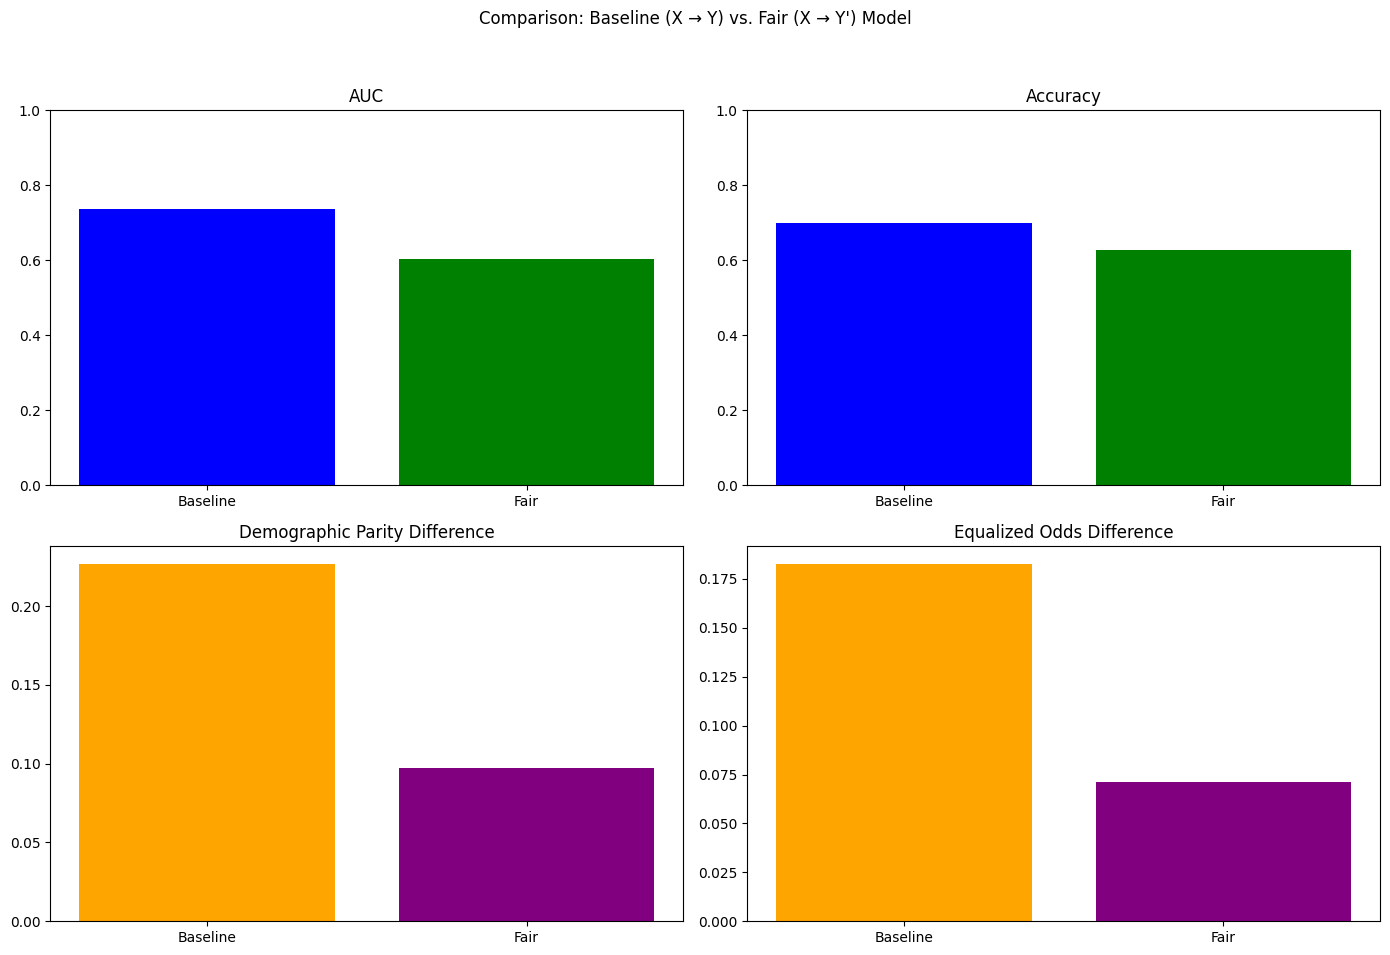

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing for COMPAS Data
# -------------------------------
def load_and_preprocess_compas_data(data_url):
    """
    Download and preprocess the COMPAS dataset.

    We assume the dataset contains, among others, the following columns:
      - 'age'
      - 'race'
      - 'priors_count'
      - 'juv_fel_count'
      - 'juv_misd_count'
      - 'juv_other_count'
      - 'two_year_recid'

    Features (X): We select a few numerical features.
    Observed Label (Y): Use 'two_year_recid' as a binary label (0/1).
    Protected Attribute (S): Use 'race'. Here we binarize race so that:
         African‑American  → 1
         all other races  → 0.
    """
    data = pd.read_csv(data_url)
    # Drop rows with missing values in the selected columns.
    data = data.dropna(subset=["age", "race", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count", "two_year_recid"])

    # Observed label: two_year_recid (already 0/1)
    Y = data["two_year_recid"].values

    # Sensitive attribute: race. We set S=1 if race is African-American, else 0.
    S = (data["race"] == "African-American").astype(int).values

    # Features: use a subset of numerical features.
    feature_cols = ["age", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count"]
    X = data[feature_cols].copy().astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values)

    return X, Y, S

# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Encoder branch: from X, dense layers produce pseudo_Y (scalar via sigmoid).
      - Adversary branch: applies a Gradient Reversal Layer on pseudo_Y and predicts S (2-class softmax).
      - Decoder branch: concatenates pseudo_Y and S (one-hot) to predict the observed label Y.
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # S one-hot encoded

    # Encoder branch.
    h = tf.keras.layers.Dense(64, activation='relu')(X_input)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dense(32, activation='relu')(h)
    h = tf.keras.layers.BatchNormalization()(h)
    pseudo_Y = tf.keras.layers.Dense(1, activation='sigmoid', name="pseudo_Y")(h)

    # Adversary branch.
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = tf.keras.layers.Dense(32, activation='relu')(grl)
    a = tf.keras.layers.BatchNormalization()(a)
    S_pred = tf.keras.layers.Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch.
    concat = tf.keras.layers.Concatenate()([pseudo_Y, S_input])
    d = tf.keras.layers.Dense(16, activation='relu')(concat)
    d = tf.keras.layers.BatchNormalization()(d)
    Y_pred = tf.keras.layers.Dense(1, activation='sigmoid', name="Y_pred")(d)

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "binary_crossentropy",
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "binary_crossentropy"},
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"})
    return model

# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually.
    y_true: binary ground-truth labels.
    y_pred: continuous scores (thresholded at 0.5 for binary predictions).
    sensitive_features: 1-D numpy array (e.g., 0 or 1).

    Returns a dictionary with:
      - Demographic parity difference.
      - Equalized odds difference.
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_bin = (y_pred > 0.5).astype(int)
    groups = np.unique(sensitive_features)

    pos_rates = {}
    for g in groups:
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1])

    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8)
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8)
        metrics[g] = (tpr, fpr)
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) / 2

    sel_rate = {}
    for g in groups:
        sel_rate[g] = pos_rates[g]

    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }

# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -------------------------------
# Utility: Seed Setting
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

# -------------------------------
# Main Function: COMPAS Data Comparison
# -------------------------------
def main_compas(data_url, lambda_adv=1.0):
    set_seed(42)

    print("Loading and preprocessing COMPAS data...")
    X, Y_obs, S_raw = load_and_preprocess_compas_data(data_url)
    # S_raw is already binary (0 or 1) per our processing.
    S = S_raw

    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )

    print(f"Features shape: {X.shape}")
    print(f"Observed Label Y shape: {Y_obs.shape}   (Recidivism: 1=recid, 0=non-recid)")
    print(f"Sensitive Attribute (Race, binarized) shape: {S.shape}")

    input_dim = X_train.shape[1]

    # One-hot encode S for the adversarial model.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model on COMPAS data.
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)
    Y_train_obs_exp = Y_train_obs.reshape(-1, 1)
    Y_test_obs_exp  = Y_test_obs.reshape(-1, 1)

    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_obs_exp, "S_pred": S_train_oh, "Y_pred": Y_train_obs_exp},
                  epochs=30, batch_size=128, verbose=1)

    # Get pseudo‑label predictions.
    pseudo_Y_train, _, _ = adv_model.predict([X_train, S_train_oh])
    pseudo_Y_test,  _, _ = adv_model.predict([X_test, S_test_oh])

    # Threshold to get binary pseudo‑labels.
    pseudo_Y_train_bin = (pseudo_Y_train > 0.5).astype(np.float32)
    pseudo_Y_test_bin  = (pseudo_Y_test > 0.5).astype(np.float32)

    print("\nPseudo‑label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo‑positive rate: {np.mean(pseudo_Y_train_bin[mask]):.4f}")

    ### 2. Train baseline logistic regression classifier (X → Y)
    print("\nTraining baseline logistic regression classifier (X → Y)...")
    baseline_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    baseline_clf.fit(X_train, Y_train_obs)
    baseline_preds = baseline_clf.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(Y_test_obs, baseline_preds)
    baseline_acc = accuracy_score(Y_test_obs, (baseline_preds > 0.5).astype(int))
    baseline_fairness = compute_fairness_metrics_manual(Y_test_obs, baseline_preds, sensitive_features=S_test)

    ### 3. Train fair logistic regression classifier on pseudo‑labels (X → Y')
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo‑labels...")
    fair_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    fair_clf.fit(X_train, pseudo_Y_train_bin.ravel())
    fair_preds = fair_clf.predict_proba(X_test)[:, 1]
    fair_auc = roc_auc_score(Y_test_obs, fair_preds)
    fair_acc = accuracy_score(Y_test_obs, (fair_preds > 0.5).astype(int))
    fair_fairness = compute_fairness_metrics_manual(Y_test_obs, fair_preds, sensitive_features=S_test)

    # Aggregate metrics.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparisons.
    plot_comparison(metrics_baseline, metrics_fair)

# -------------------------------
# Run the COMPAS Analysis
# -------------------------------
if __name__ == '__main__':
    # URL for the ProPublica COMPAS dataset
    compas_data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    # You can adjust lambda_adv as desired (e.g., lambda_adv=15.5 as in your German data experiment)
    main_compas(compas_data_url, lambda_adv=3.1)


o3


O3
